In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import time
import os
import sys
import copy
import math
import matplotlib.pyplot as plt
from torx.module.layer import *
from benchmark import replace_layers
import argparse
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
# from torchsummary import summary
from resnet import *
from mobilenet import *
from VGG import *
from densenet import * 
import json

87.54349610085917 -0.006931471805599453


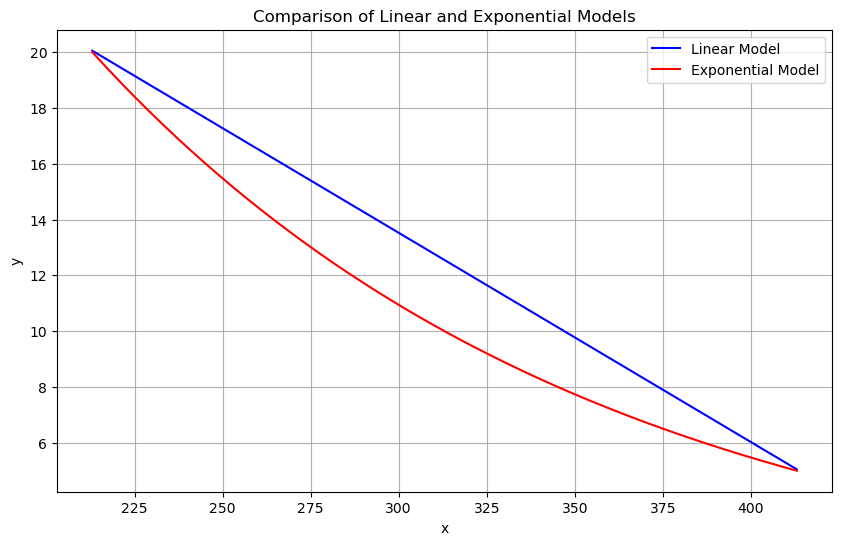

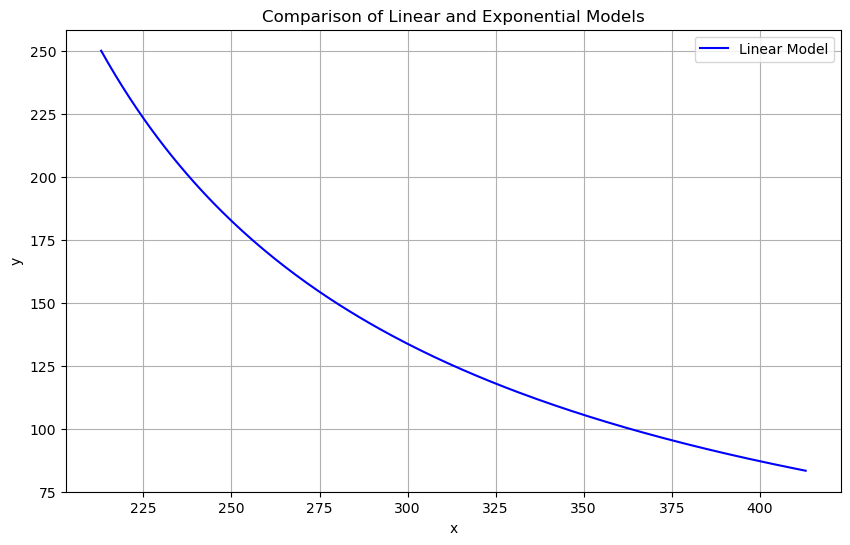

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the linear model
def linear_model(x):
    return -0.075 * x + 36.025
G_on = 250
def paper_model(x):
    return 1/(0.01*(x-213) +1)*G_on

# Define the exponential model with corrected parameters using numpy for array operations
def exponential_model(x):
    # Parameters determined based on y(213) = 20 and y(413) = 5
    b = np.log(0.25) / 200  # Rate of decay
    a = 20 / np.exp(b * 213)  # Scale factor to start at 20 when x = 213
    print(a,b)
    return a * np.exp(b * x)

# Define the range of x values
x_values = np.linspace(213, 413, 200)

# Calculate y values for both functions
y_linear = linear_model(x_values)
y_exponential = exponential_model(x_values)
y_paper = paper_model(x_values)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_linear, label='Linear Model', color='blue')
plt.plot(x_values, y_exponential, label='Exponential Model', color='red')
plt.title('Comparison of Linear and Exponential Models')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_paper, label='Linear Model', color='blue')
plt.title('Comparison of Linear and Exponential Models')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
print(exponential_model(300))
print(linear_model(300))

print(exponential_model(300)/exponential_model(340))
print(linear_model(300)/linear_model(340))

87.54349610085917 -0.006931471805599453
10.942937012607395
13.524999999999999
87.54349610085917 -0.006931471805599453
87.54349610085917 -0.006931471805599453
1.3195079107728938
1.2850356294536818


In [13]:
print(paper_model(300))
print((paper_model(300)-paper_model(325))/paper_model(300))
print((paper_model(300)-paper_model(350))/paper_model(300))
print((paper_model(300)-paper_model(380))/paper_model(300))

133.68983957219248
0.11792452830188668
0.210970464135021
0.2996254681647938


In [14]:
import torch

# Example tensor with shape (3, 4) -- 3 samples, 4 features each
tensor = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])
def replicate_last_dimension(tensor, num_times):
    if num_times <= 0:
        raise ValueError("The number of times to replicate must be positive.")
    
    # Get the original shape of the tensor
    *leading_dims, last_dim = tensor.shape

    # Reshape the tensor to prepare for replication
    tensor = tensor.unsqueeze(-1)  # Add a new dimension after the last dimension

    # Repeat the tensor along the new dimension
    replicated_tensor = tensor.repeat_interleave(num_times, dim=-1)

    # Reshape the tensor to merge the replicated dimension with the original last dimension
    replicated_tensor = replicated_tensor.view(*leading_dims, num_times * last_dim)

    return replicated_tensor

# Replicate each feature twice
replicated_tensor = replicate_last_dimension(tensor, 2)
print(replicated_tensor)


tensor([[ 1,  1,  2,  2,  3,  3,  4,  4],
        [ 5,  5,  6,  6,  7,  7,  8,  8],
        [ 9,  9, 10, 10, 11, 11, 12, 12]])


In [1]:
import torch

def elementwise_max(tensor1, tensor2):
    """
    Compute the element-wise maximum of two tensors.

    :param tensor1: First input tensor.
    :param tensor2: Second input tensor.
    :return: A new tensor containing the maximum values at each element.
    """
    return torch.max(tensor1, tensor2)
# Define two tensors of the same shape
tensor1 = torch.tensor([[1, 4, 3], [1, 5, 6]])
tensor2 = torch.tensor([[3, 2, 5], [7, 1, 4]])

# Compute the element-wise max
max_tensor = elementwise_max(tensor1, tensor2)
print(max_tensor)


tensor([[3, 4, 5],
        [7, 5, 6]])


In [8]:
##Load the data 
path = f'./statistics/cifar10/resnet18/resnet18_class_0_names.pt'
resnet18_ec = torch.load(path)
# print(resnet18_ec['conv_2'].shape)
print(resnet18_ec)

['Conv3x3_0_', 'Conv3x3_1_', 'Conv3x3_2_', 'Conv3x3_3_', 'Conv3x3_4_', 'Conv3x3_5_', 'Conv3x3_6_', 'Conv1x1_7_', 'Conv3x3_8_', 'Conv3x3_9_', 'Conv3x3_10_', 'Conv3x3_11_', 'Conv1x1_12_', 'Conv3x3_13_', 'Conv3x3_14_', 'Conv3x3_15_', 'Conv3x3_16_', 'Conv1x1_17_', 'Conv3x3_18_', 'Conv3x3_19_', 'FC_20_']


In [1]:
models = ['resnet18', 'vgg11', 'vgg16']
for model_name in models:
    for class_num in range(10):
        path_names = f'./statistics/cifar10/{model_name}/{model_name}_class_{class_num}_names.pt'
        path_outputs = f'./statistics/cifar10/{model_name}/{model_name}_class_{class_num}_outputs.pt'
        path_padding = f'./statistics/cifar10/{model_name}/{model_name}_class_{class_num}_padding.pt'
        path_stride = f'./statistics/cifar10/{model_name}/{model_name}_class_{class_num}_stride.pt'
        path_weight_shape = f'./statistics/cifar10/{model_name}/{model_name}_class_{class_num}_weight_shape.pt'
        names = torch.load(path_names)
        outputs = torch.load(path_outputs)
        padding = torch.load(path_padding)
        stride = torch.load(path_stride)
        weight_shape = torch.load(path_weight_shape)
        
        

NameError: name 'torch' is not defined

In [4]:
##Print the data 
# print(resnet18_ec)
# print(vgg16_ec)
# print(densenet121_ec)

##find the avg and std with respect to each key in the loaded dictionary
def avg_std(data):
    avg = {}
    std = {}
    for key in data.keys():
        avg[key] = np.mean(data[key])
        std[key] = np.std(data[key])
    return avg, std
resnet18_avg, resnet18_std = avg_std(resnet18_ec)
vgg16_avg, vgg16_std = avg_std(vgg16_ec)
densenet121_avg, densenet121_std = avg_std(densenet121_ec)
##print the avg and std
print("resnet18_avg",resnet18_avg)
print("resnet18_std",resnet18_std)
print("vgg16_avg",vgg16_avg)
print("vgg16_std",vgg16_std)
print("densenet121_avg",densenet121_avg)
print("densenet121_std",densenet121_std)


TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [ ]:
##convert the avg dict to excel using pandas dataframe 
import pandas as pd
resnet18_avg_df = pd.DataFrame(resnet18_avg, index=[0])
vgg16_avg_df = pd.DataFrame(vgg16_avg, index=[0])
densenet121_avg_df = pd.DataFrame(densenet121_avg, index=[0])
##save as excel files
resnet18_avg_df.to_excel('cifar-10/resnet18_wc_avg.xlsx', index=False)
vgg16_avg_df.to_excel('cifar-10/vgg16_wc_avg.xlsx', index=False)
densenet121_avg_df.to_excel('cifar-10/densenet121_wc_avg.xlsx', index=False)


In [ ]:
resnet18_e = torch.load('cifar-10/resnet18_cifar10_worst_case_error.pth')
# vgg16_ec = torch.load('cifar-10/vgg16_cifar10_worst_case_error_ec.pth')
densenet121_e= torch.load('cifar-10/densenet121_cifar10_worst_case_error.pth')

In [ ]:
resnet18_avg, resnet18_std = avg_std(resnet18_e)
# vgg16_avg, vgg16_std = avg_std(vgg16_ec)
densenet121_avg, densenet121_std = avg_std(densenet121_e)
##print the avg and std
print("resnet18_avg",resnet18_avg)
print("resnet18_std",resnet18_std)
# print("vgg16_avg",vgg16_avg)
# print("vgg16_std",vgg16_std)
print("densenet121_avg",densenet121_avg)
print("densenet121_std",densenet121_std)

resnet18_avg {'fault_0.1': 19.741999999999997, 'fault_0.5': 10.007, 'fault_1.0': 9.7895, 'fault_5.0': 5.677, 'fault_10.0': 10.0155, 'fault_20.0': 10.0}
resnet18_std {'fault_0.1': 0.11052601503718468, 'fault_0.5': 0.05386093203798084, 'fault_1.0': 0.08930145575521153, 'fault_5.0': 0.12981140165640304, 'fault_10.0': 0.028892040426387374, 'fault_20.0': 0.0}
densenet121_avg {'fault_0.1': 41.180499999999995, 'fault_0.5': 11.3325, 'fault_1.0': 9.9895, 'fault_5.0': 9.6075, 'fault_10.0': 9.921499999999998, 'fault_20.0': 9.9655}
densenet121_std {'fault_0.1': 0.13150950535987868, 'fault_0.5': 0.07299828765114973, 'fault_1.0': 0.037346351896804825, 'fault_5.0': 0.14102747959174478, 'fault_10.0': 0.1349916664094491, 'fault_20.0': 0.004974937185532994}


In [ ]:
##have to do the same for the file =s in the cifar-10/cluster folder
resnet18_e = torch.load('cifar-10/cluster/resnet18_cifar10_error.pth')
vgg16_e = torch.load('cifar-10/cluster/vgg16_cifar10_error.pth')
densenet121_e= torch.load('cifar-10/cluster/densenet121_cifar10_error.pth')

In [ ]:
resnet18_avg, resnet18_std = avg_std(resnet18_e)
gg16_avg, vgg16_std = avg_std(vgg16_e)
densenet121_avg, densenet121_std = avg_std(densenet121_e)
##print the avg and std
print("resnet18_avg",resnet18_avg)
print("resnet18_std",resnet18_std)
print("vgg16_avg",vgg16_avg)
print("vgg16_std",vgg16_std)
print("densenet121_avg",densenet121_avg)
print("densenet121_std",densenet121_std)

resnet18_avg {'fault_0.1': 93.07970000000003, 'fault_0.5': 87.935, 'fault_1.0': 39.7055, 'fault_5.0': 9.998}
resnet18_std {'fault_0.1': 0.3416619820817057, 'fault_0.5': 3.105213519228589, 'fault_1.0': 17.24523721930203, 'fault_5.0': 0.3390250728191059}


NameError: name 'vgg16_avg' is not defined

In [ ]:
resnet18_ec = torch.load('cifar-10/resnet18_cifar10_cluster_error_ec.pth')
vgg16_ec = torch.load('cifar-10/vgg16_cifar10_cluster_error_ec.pth')
densenet121_ec= torch.load('cifar-10/densenet121_cifar10_cluster_error_ec.pth')

In [ ]:
resnet18_avg, resnet18_std = avg_std(resnet18_ec)
vgg16_avg, vgg16_std = avg_std(vgg16_ec)
densenet121_avg, densenet121_std = avg_std(densenet121_ec)
##print the avg and std
print("resnet18_avg",resnet18_avg)
print("resnet18_std",resnet18_std)
print("vgg16_avg",vgg16_avg)
print("vgg16_std",vgg16_std)
print("densenet121_avg",densenet121_avg)
print("densenet121_std",densenet121_std)

resnet18_avg {'fault_0.1': 93.75800000000001, 'fault_0.5': 93.75199999999998, 'fault_1.0': 93.76500000000001, 'fault_5.0': 93.693, 'fault_10.0': 93.651, 'fault_15.0': 93.57300000000001, 'fault_20.0': 93.534, 'fault_30.0': 93.238, 'fault_40.0': 93.23299999999999, 'fault_50.0': 93.17599999999999}
resnet18_std {'fault_0.1': 0.06539113089708708, 'fault_0.5': 0.07263607918933937, 'fault_1.0': 0.06407027391856655, 'fault_5.0': 0.15258112596255174, 'fault_10.0': 0.16585837331892403, 'fault_15.0': 0.24372320365529287, 'fault_20.0': 0.21850400453996396, 'fault_30.0': 0.29952629266894265, 'fault_40.0': 0.22248820193439597, 'fault_50.0': 0.19422667170087418}
vgg16_avg {'fault_0.1': 91.79499999999999, 'fault_0.5': 91.806, 'fault_1.0': 91.795, 'fault_5.0': 91.728, 'fault_10.0': 91.695, 'fault_15.0': 91.747, 'fault_20.0': 91.687, 'fault_30.0': 91.594, 'fault_40.0': 91.631, 'fault_50.0': 91.55600000000001}
vgg16_std {'fault_0.1': 0.06682065548915261, 'fault_0.5': 0.05919459434779533, 'fault_1.0': 0.0